<h1><b>Utilizando recursos da biblioteca Scikit-Learn para avaliar modelos de Machine Learning</b></h1>
<h3>Prof. Dr. Rafael Rieder</h3>
<h4>Exemplo para aulas relacionadas ao Aprendizado de Máquina</h4>
<h5>Universidade de Passo Fundo. Última atualização: 27/10/2023</h5>

In [1]:
# Model Evaluation (Regression and Classification)
# Credits: Angelica Lo Duca
# Source: https://towardsdatascience.com/model-evaluation-in-scikit-learn-abce32ee4a99

# Changed to use as a learning resource in ML class: Rafael Rieder
# University of Passo Fundo, 2023

# Dataset: https://archive.ics.uci.edu/ml/datasets/wine+quality
# Sources:
# Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: the University of California, School of Information and Computer Science.
# P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score, fbeta_score
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Leitura dos dois arquivos de dados (vinhos tinto e branco), e concatenando-os em um só dataset. Ao final, conferindo o número de colunas e a saída exibindo os primeiros e últimos 5 registros.

In [3]:
targets = ['red', 'white']
df_list = []
df = pd.DataFrame()
mypath = f""
for target in targets:
    df_temp = pd.read_csv(mypath + f"winequality-{target}.csv", sep=';')
    df_temp['target'] = target
    df_list.append(df_temp)
    print(df_temp.shape)
df = pd.concat([df_list[0], df_list[1]])

print(df.shape)

df.head(5).append(df.tail(5))

(1599, 13)
(4898, 13)
(6497, 13)


C:\Users\samue\AppData\Local\Temp\ipykernel_10116\1179723031.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.head(5).append(df.tail(5))


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,target
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white
4897,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6,white


Função para codificar e transformar dados categóricos em numéricos. Para tanto, trabalhamos apenas com colunas do tipo "object" (e evitar em mexer em dados que já são numéricos).

In [4]:
def transform_categorical(data):
    categories = (data.dtypes =="object")
    cat_cols = list(categories[categories].index)
    label_encoder = LabelEncoder()
    for col in cat_cols:
        data[col] = label_encoder.fit_transform(data[col])

Função para dimensionar colunas numéricas (transformar as características dos dados, para deixá-las na mesma escala em um determinado intervalo - no caso, entre 0 e 1).

In [5]:
def scale_numerical(data):
    scaler = MinMaxScaler()
    data[data.columns] = scaler.fit_transform(data[data.columns])

<h2><b>Avaliando modelos de regressão</b></h2>
<p>Métricas a serem aplicadas:</p>


*   Erro médio absoluto (MAE): a média da diferença entre o valor real e o previsto. Ele mede a distância entre as previsões e a saída real. Quanto menor o MAE, melhor o modelo;
*   Raiz quadrada do erro médio (RMSE): a raiz quadrada do erro quadrático médio (MSE) calcula a média do quadrado da diferença entre os valores reais e os previstos. Usada para expressar a acurácia dos resultados numéricos;
*   R² score (coeficiente de determinação): proporção de variância em Y que pode ser explicada por X. Mostra quanto o modelo se ajusta à amostra (quanto maior o R², melhor o ajuste).



<u>Tarefa: prever o pH de cada registro, considerando as demais características.</u>
Começamos retirando a coluna de pH do conjunto, salvando essa estrutura em X.
Em seguida, salvamos só a coluna pH em Y.

In [6]:
X = df.drop("pH", axis = 1)
y = df["pH"]

Transformando categorias em números, e normalizando números na escala 0-1:

In [7]:
transform_categorical(X)
scale_numerical(X)
X.head(5).append(X.tail(5))

C:\Users\samue\AppData\Local\Temp\ipykernel_10116\301952732.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X.head(5).append(X.tail(5))


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,sulphates,alcohol,quality,target
0,0.297521,0.413333,0.000000,0.019939,0.111296,0.034722,0.064516,0.206092,0.191011,0.202899,0.333333,0.0
1,0.330579,0.533333,0.000000,0.030675,0.147841,0.083333,0.140553,0.186813,0.258427,0.260870,0.333333,0.0
2,0.330579,0.453333,0.024096,0.026074,0.137874,0.048611,0.110599,0.190669,0.241573,0.260870,0.333333,0.0
3,0.611570,0.133333,0.337349,0.019939,0.109635,0.055556,0.124424,0.209948,0.202247,0.260870,0.500000,0.0
4,0.297521,0.413333,0.000000,0.019939,0.111296,0.034722,0.064516,0.206092,0.191011,0.202899,0.333333,0.0
4893,0.198347,0.086667,0.174699,0.015337,0.049834,0.079861,0.198157,0.077694,0.157303,0.463768,0.500000,1.0
4894,0.231405,0.160000,0.216867,0.113497,0.063123,0.194444,0.373272,0.150183,0.134831,0.231884,0.333333,1.0
4895,0.223140,0.106667,0.114458,0.009202,0.053156,0.100694,0.241935,0.104685,0.134831,0.202899,0.500000,1.0
4896,0.140496,0.140000,0.180723,0.007669,0.021595,0.065972,0.239631,0.030461,0.089888,0.695652,0.666667,1.0
4897,0.181818,0.086667,0.228916,0.003067,0.018272,0.072917,0.211982,0.044342,0.056180,0.550725,0.500000,1.0


Dividindo os datasets X e Y em conjuntos de treino e teste.
Definiu-se o tamanho do conjunto de teste em 20% (logo, treino será 80%). Já "random_state" é usado para reproduzir o problema da mesma forma toda vez que é executado (controla o "embaralhamento").

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Função para rodar o modelo (fit), realizar as predições (predict) e calcular os scores de desempenho) para técnicas de Regressão aplicadas.

Resultados do experimento de regressão:
Mean Squared Error (MSE): 0.009528382991175985
Mean Absolute Error (MAE): 0.07476031320105746
R-squared (R2): 0.6508427991759349


Construindo um modelo de Regressão Linear, e testando seu desempenho na predição de resultados:

In [28]:
def run_experiment_regression(model, X, y):
   
    # Ajustar o modelo aos dados de treinamento
    model.fit(X_train, y_train)
    
    # Fazer previsões nos dados de teste
    y_pred = model.predict(X_test)
    
    # Calcular métricas de desempenho
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Retornar as métricas de desempenho
    return {
        "R Mean Squared Error (MSE)": rmse,
        "Mean Absolute Error (MAE)": mae,
        "R-squared (R2)": r2
    }

# Exemplo de uso com uma regressão linear
from sklearn.linear_model import LinearRegression

# Criar um modelo de regressão linear
modelo_regressao_linear = LinearRegression()

# Executar o experimento
resultados = run_experiment_regression(modelo_regressao_linear, X, y)

# Imprimir os resultados
print("Resultados do experimento de regressão:")
for metric, valor in resultados.items():
    print(f"{metric}: {valor}")
    # inserir código aqui

Resultados do experimento de regressão:
R Mean Squared Error (MSE): 0.16552521873854248
Mean Absolute Error (MAE): 0.11955029528691485
R-squared (R2): 0.8584069100420234


Construindo um modelo de Gradiente Descendente Estocástico, e testando seu desempenho na predição de resultados:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Criar um modelo de Gradiente Descendente Estocástico para regressão
modelo_sgd = SGDRegressor(random_state=42)

# Ajustar o modelo aos dados de treinamento
modelo_sgd.fit(X_train, y_train)

# Fazer previsões nos dados de teste
y_pred = modelo_sgd.predict(X_test)

# Calcular métricas de desempenho
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir os resultados
print("Métricas de desempenho do modelo de Gradiente Descendente Estocástico:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Métricas de desempenho do modelo de Gradiente Descendente Estocástico:
Mean Squared Error (MSE): 0.03578721374304392
Mean Absolute Error (MAE): 0.14809500235285958
R-squared (R2): -0.3113834096913817


Construindo um modelo de regressão Random Forest, e testando seu desempenho na predição de resultados:

In [11]:
# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Criar um modelo de regressão Random Forest
modelo_random_forest = RandomForestRegressor(random_state=42)

# Ajustar o modelo aos dados de treinamento
modelo_random_forest.fit(X_train, y_train)

# Fazer previsões nos dados de teste
y_pred = modelo_random_forest.predict(X_test)

# Calcular métricas de desempenho
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir os resultados
print("Métricas de desempenho do modelo de regressão Random Forest:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Métricas de desempenho do modelo de regressão Random Forest:
Mean Squared Error (MSE): 0.006947956984615391
Mean Absolute Error (MAE): 0.05862015384615388
R-squared (R2): 0.7453996953689919


<h2><b>Avaliando modelos de classificação</b></h2>
<p>Métricas a serem aplicadas: </p>

*   Matriz de confusão: gráfico para verificar verdadeiros positivos, verdadeiros negativos, falsos positivos e falsos negativos. Indica os erros e acertos do seu modelo, comparando com o resultado esperado;
*   Acurácia: medida intuitiva que indica uma performance geral do modelo. Dentre todas as classificações, quantas o modelo classificou corretamente;
*   Precisão: dentre todas as classificações de classe Positivo que o modelo fez, mostra quantas estão corretas. A precisão pode ser usada em uma situação em que os Falsos Positivos são considerados mais prejudiciais que os Falsos Negativos;
*   Revocação/ Sensibilidade (Recall): dentre todas as situações de classe Positivo como valor esperado, quantas estão corretas. Pode ser usada em uma situação em que os Falsos Negativos são considerados mais prejudiciais que os Falsos Positivos;
*   F1-Score: média harmônica entre precisão e recall. Ele será alto quando ambas as métricas base forem altas e similares, ou seja, é maior quando há um "meio termo" entre precisão e recall;
*   Curva ROC: mostra a relação entre a taxa de verdadeiros positivos (true positive rate — TPR) e a taxa de falsos positivos (false positive rate — FPR) para diferentes thresholds. Se a curva ROC de um modelo se aproxima bastante do ponto (0.0, 1.0), na parte alta e esquerda do gráfico, esse modelo é bom;
*   ROC AUC Score: para medir a proximidade com o ponto (0.0, 1.0) utiliza-se a área sob a curva ROC (area under the curve — AUC). Quanto mais próximo de 1.0 é o score da área sob a curva ROC, melhor é o modelo;
*   Curva Precision-Recall: plota a relação entre precisão e revocação à medida que o limite de decisão é alterado. Uma boa curva PR tem maior AUC (área sob a curva). A precisão ajuda a destacar a relevância dos resultados de revocação (quanto mais próximo das partes alta e direita do gráfico, melhor);
*   Average Precision (AP): área debaixo da curva de precision X recall. Útil para comparar diferentes modelos de detecção de objetos.

<u>Tarefa: prever o tipo de vinho (tinto ou branco).</u>
Começamos retirando a coluna "target" do conjunto, salvando essa estrutura em X.
Em seguida, salvamos só a coluna "target" em Y.

In [12]:
X = df.drop("target", axis = 1)
y = df["target"]

Transformando categorias em números, e normalizando números na escala 0-1:

In [13]:
transform_categorical(X)
scale_numerical(X)

Transformar também as classes de vinho (0 e 1):

In [14]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

Dividindo os datasets X e Y em conjuntos de treino e teste.
Definiu-se o tamanho do conjunto de teste em 20% (logo, treino será 80%). Já "random_state" é usado para reproduzir o problema da mesma forma toda vez que é executado (controla o "embaralhamento").

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Função para rodar o modelo (fit), realizar as predições (predict) e calcular os scores de desempenho) para técnicas de Classificação aplicadas.

In [ ]:
def run_experiment_classification(model, name):
    # inserir código aqui

Construindo um modelo de Random Forest, e testando seu desempenho na predição de resultados:

In [16]:
modelo_random_forest = RandomForestRegressor(random_state=42)

# Ajustar o modelo aos dados de treinamento
modelo_random_forest.fit(X_train, y_train)

# Fazer previsões nos dados de teste
y_pred = modelo_random_forest.predict(X_test)

# Calcular métricas de desempenho
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir os resultados
print("Métricas de desempenho do modelo Random Forest para regressão:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Métricas de desempenho do modelo Random Forest para regressão:
Mean Squared Error (MSE): 0.008230285256410256
Mean Absolute Error (MAE): 0.02025
R-squared (R2): 0.9574667463256468


Construindo um modelo de Árvore de Decisão, e testando seu desempenho na predição de resultados:

In [17]:
from sklearn.tree import DecisionTreeRegressor
# Criar um modelo de Árvore de Decisão para regressão
modelo_arvore_decisao = DecisionTreeRegressor(random_state=42)

# Ajustar o modelo aos dados de treinamento
modelo_arvore_decisao.fit(X_train, y_train)

# Fazer previsões nos dados de teste
y_pred = modelo_arvore_decisao.predict(X_test)

# Calcular métricas de desempenho
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir os resultados
print("Métricas de desempenho do modelo de Árvore de Decisão para regressão:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Métricas de desempenho do modelo de Árvore de Decisão para regressão:
Mean Squared Error (MSE): 0.016923076923076923
Mean Absolute Error (MAE): 0.016923076923076923
R-squared (R2): 0.9125433078811934


Construindo um modelo de Análise Discriminante Linear, e testando seu desempenho na predição de resultados:

In [19]:
from sklearn.metrics import accuracy_score, classification_report
# Criar um modelo de Análise Discriminante Linear (LDA)
modelo_lda = LinearDiscriminantAnalysis()

# Ajustar o modelo aos dados de treinamento
modelo_lda.fit(X_train, y_train)

# Fazer previsões nos dados de teste
y_pred = modelo_lda.predict(X_test)

# Calcular a acurácia do modelo
acuracia = accuracy_score(y_test, y_pred)

# Imprimir a acurácia e o relatório de classificação
print(f"Acurácia do modelo: {acuracia}")
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))

Acurácia do modelo: 0.9930769230769231
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       341
           1       0.99      1.00      1.00       959

    accuracy                           0.99      1300
   macro avg       0.99      0.99      0.99      1300
weighted avg       0.99      0.99      0.99      1300



In [29]:
def run_experiment_classification(model, name):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='GnBu')
    _ = disp.ax_.set_title("Matriz de confusÃ£o")
    plt.show()

    print('====================')
    print('Precision....: %.3f' % precision_score(y_test, y_pred))
    print('Recall.......: %.3f' % recall_score(y_test, y_pred))
    print('F1 Score.....: %.3f' % f1_score(y_test, y_pred))
    print('Accuracy.....: %.3f' % accuracy_score(y_test, y_pred))
    print('F-Beta Score.: %.3f' % fbeta_score(y_test, y_pred, average='micro', beta=0.5))
    print('Roc AUC Score: %.3f' % roc_auc_score(y_test, y_pred, average='micro'))
    print('====================')

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC')
    plt.plot(fpr, tpr)
    plt.show()

    print('')
    pr, rc, th = precision_recall_curve(y_test, y_pred)
    disp = PrecisionRecallDisplay(precision=pr, recall=rc, estimator_name=name, average_precision=average_precision_score(y_test, y_pred, average='micro'))
    disp.plot()
    _ = disp.ax_.set_title("Curva Precision Recall")
    plt.show()

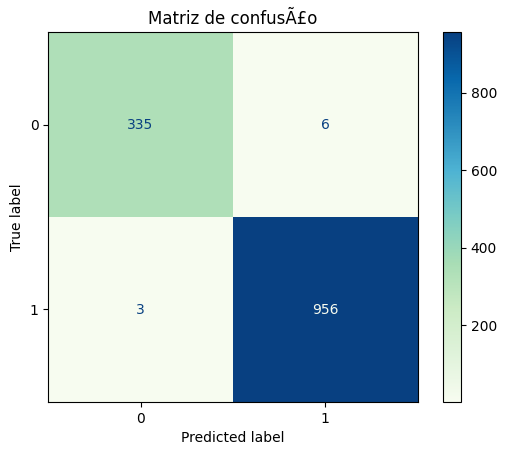

Precision....: 0.994
Recall.......: 0.997
F1 Score.....: 0.995
Accuracy.....: 0.993
F-Beta Score.: 0.993
Roc AUC Score: 0.990


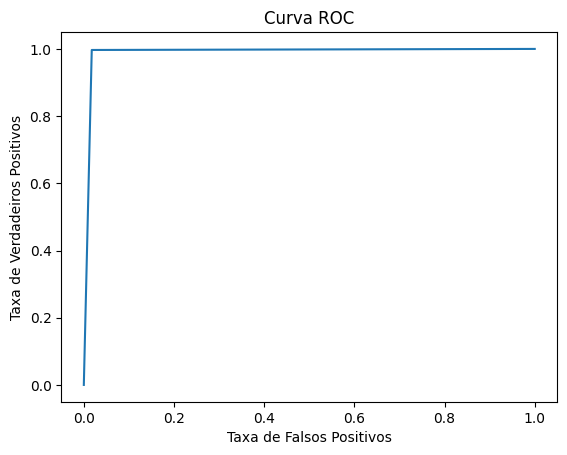

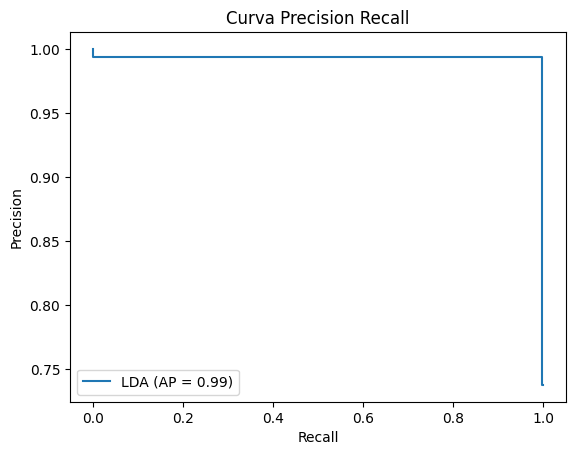

In [30]:
run_experiment_classification(modelo_lda, "LDA")